# Train

In [10]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define your transformations
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = datasets.ImageFolder(root='dataset/train', transform=transform)
val_dataset = datasets.ImageFolder(root='dataset/val', transform=transform)

print(train_dataset.class_to_idx)
print(val_dataset.class_to_idx)

# Create Data Loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

{'10526_Armillaria_mellea': 0, '10527_Armillaria_ostoyae': 1, '10934_Auricularia_auricula-judae': 2, '10937_Auricularia_mesenterica': 3, '11069_Boletus_edulis': 4, '11083_Boletus_pinophilus': 5, '11093_Boletus_reticulatus': 6, '11314_Cantharellus_amethysteus': 7, '11317_Cantharellus_cibarius': 8, '11325_Cantharellus_pallens': 9, '11746_Clitocybe_agrestis': 10, '11748_Clitocybe_alexandri': 11, '11760_Clitocybe_diatreta': 12, '11762_Clitocybe_ditopus': 13, '11767_Clitocybe_fragrans': 14, '11787_Clitocybe_metachroa': 15, '11796_Clitocybe_phaeophthalma': 16, '11797_Clitocybe_phyllophila': 17, '11803_Clitocybe_rivulosa': 18, '11813_Clitocybe_trulliformis': 19, '11816_Clitocybe_vibecina': 20, '12763_Hericium_cirrhatum': 21, '14056_Flammulina_velutipes var. velutipes': 22, '14155_Ganoderma_adspersum': 23, '14158_Ganoderma_applanatum': 24, '14159_Ganoderma_lucidum': 25, '14160_Ganoderma_pfeifferi': 26, '14161_Ganoderma_resinaceum': 27, '14394_Grifola_frondosa': 28, '14667_Hericium_coralloides'

In [11]:
import torch
from torch import nn
import torch.nn.functional as F

# Load Pre-trained DeiT Model
model = torch.hub.load('facebookresearch/deit:main', 'deit_base_patch16_224', pretrained=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Adjust the classifier for your number of classes
num_classes = len(train_dataset.classes)
model.head = nn.Linear(model.head.in_features, num_classes)
# model.eval()

Using cache found in /home/samxu/.cache/torch/hub/facebookresearch_deit_main


In [12]:
# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the last layers
for param in model.head.parameters():
    param.requires_grad = True

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

In [14]:
import copy
from tqdm import tqdm

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    best_acc = 0.0
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            data_loader = train_loader if phase == 'train' else val_loader
            for inputs, labels in tqdm(data_loader, desc=f"Epoch {epoch+1}/{num_epochs} [{phase}]"):
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(data_loader.dataset)
            epoch_acc = running_corrects.double() / len(data_loader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    print(f'Best val Acc: {best_acc:4f}')
    model.load_state_dict(best_model_wts)
    return model

In [15]:
# Train the model
# trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=100)

In [20]:
model_path = 'weight/deit_fungus25_epoch100.pt'
# torch.save(model.state_dict(), model_path)

# Inference

In [21]:
import os

model = torch.hub.load('facebookresearch/deit:main', 'deit_base_patch16_224', pretrained=True)
class_names = os.listdir('dataset/train')
class_names.sort()
model.head = nn.Linear(model.head.in_features, num_classes)

model.load_state_dict(torch.load(model_path))
model.to(device)
model.eval()

Using cache found in /home/samxu/.cache/torch/hub/facebookresearch_deit_main


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [22]:
def infer_image(image_path, model, transform, device):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        outputs = model(image)
        probabilities = F.softmax(outputs, dim=1)
        max_probs, preds = torch.max(probabilities, 1)
        return preds.item(), max_probs.item()

In [35]:
import os
import random
import glob

image_dirs = glob.glob('dataset/val/*/')
image_list = []

for directory in image_dirs:
    files_in_dir = [os.path.join(directory, file) for file in os.listdir(directory)]
    image_list.extend(files_in_dir)

# Randomly sample 5 files from the combined list
image_files = random.sample(image_list, 5)

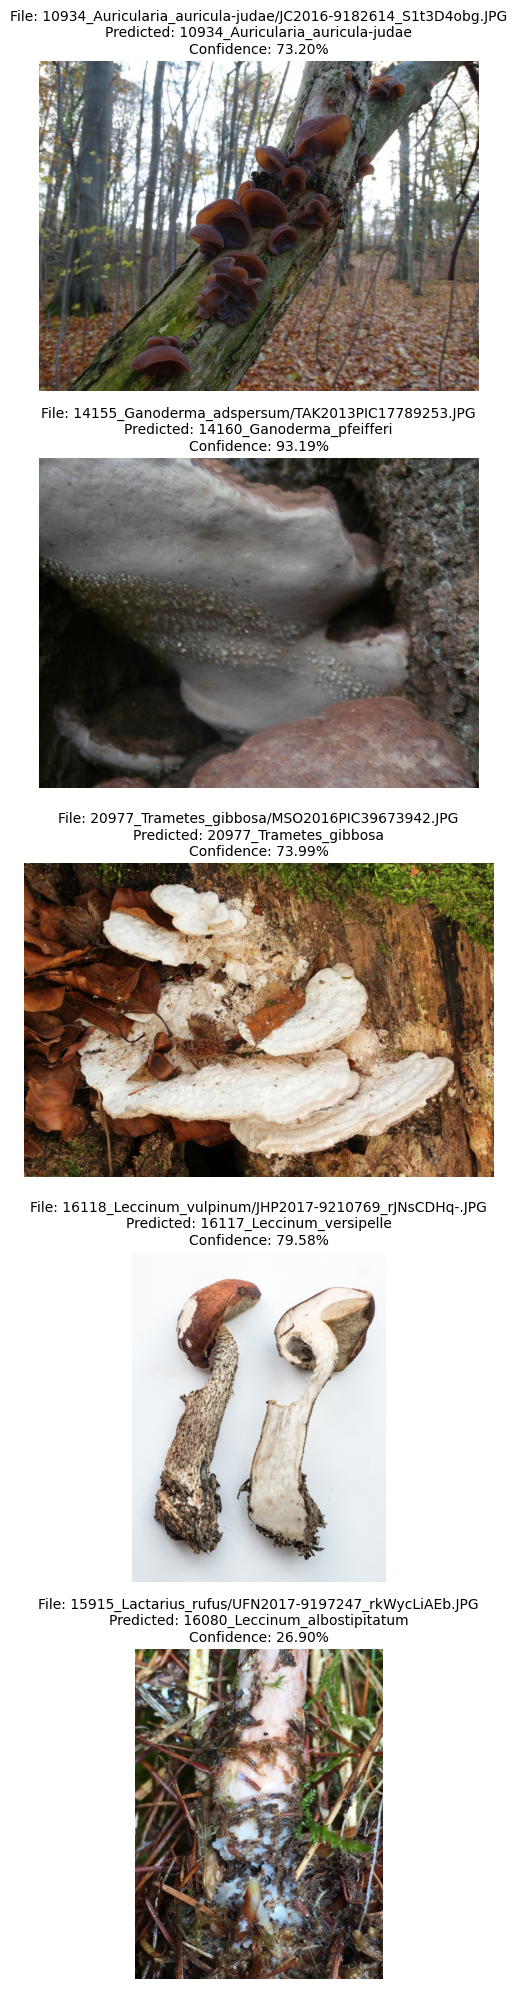

In [36]:
import matplotlib.pyplot as plt
from PIL import Image

num_images = 5
fig, axs = plt.subplots(num_images, 1, figsize=(5, num_images * 4))

for i, image_path in enumerate(image_files):
    pred_class, confidence = infer_image(image_path, model, transform, device)
    class_name = class_names[pred_class]
    confidence_prec = confidence * 100

    parent_dir = os.path.basename(os.path.dirname(image_path))
    display_path = os.path.join(parent_dir, os.path.basename(image_path))
    
    img = Image.open(image_path)
    axs[i].imshow(img)
    axs[i].set_title(f'File: {display_path}\nPredicted: {class_name}\nConfidence: {confidence_prec:.2f}%', fontsize=10)
    axs[i].axis('off')

plt.tight_layout()
plt.show()

# Model Convert

In [15]:
model.eval()

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

### Scripting

In [18]:
model_name, extension = os.path.splitext(model_path)

scripted_model = torch.jit.script(model)
scripted_model.save(model_path + "-scripted.pt")

### Quantizing

In [20]:
backend = "qnnpack"
model.qconfig = torch.quantization.get_default_qconfig(backend)
torch.backends.quantized.engine = backend

model = model.cpu()

quantized_model = torch.quantization.quantize_dynamic(model, qconfig_spec={torch.nn.Linear}, dtype=torch.qint8)
scripted_quantized_model = torch.jit.script(quantized_model)
scripted_quantized_model.save(model_path + "-scripted_quantized.pt")

### Optimizing

In [21]:
from torch.utils.mobile_optimizer import optimize_for_mobile

optimized_scripted_quantized_model = optimize_for_mobile(scripted_quantized_model)
optimized_scripted_quantized_model.save(model_path + "-optimized_scripted_quantized.pt")

### Using Lite Interpreter

In [22]:
optimized_scripted_quantized_model._save_for_lite_interpreter(model_path + "-optimized_scripted_quantized_lite.ptl")
ptl = torch.jit.load(model_path + "-optimized_scripted_quantized_lite.ptl")

### Comparing Inference Speed

In [30]:
test_img = Image.open("dataset/test/Pleurotus_sp..jpg")
test_img = transform(test_img)[None,]
out = model(test_img)
clsidx = torch.argmax(out)
print(clsidx.item())
print(class_names[clsidx.item()])

98
18871_Pleurotus_pulmonarius


In [32]:
with torch.autograd.profiler.profile(use_cuda=False) as prof1:
    out = model(test_img)
with torch.autograd.profiler.profile(use_cuda=False) as prof2:
    out = scripted_model(test_img)
with torch.autograd.profiler.profile(use_cuda=False) as prof3:
    out = scripted_quantized_model(test_img)
with torch.autograd.profiler.profile(use_cuda=False) as prof4:
    out = optimized_scripted_quantized_model(test_img)
with torch.autograd.profiler.profile(use_cuda=False) as prof5:
    out = ptl(test_img)

print("original model: {:.2f}ms".format(prof1.self_cpu_time_total/1000))
print("scripted model: {:.2f}ms".format(prof2.self_cpu_time_total/1000))
print("scripted & quantized model: {:.2f}ms".format(prof3.self_cpu_time_total/1000))
print("scripted & quantized & optimized model: {:.2f}ms".format(prof4.self_cpu_time_total/1000))
print("lite model: {:.2f}ms".format(prof5.self_cpu_time_total/1000))

STAGE:2023-11-20 16:03:56 407676:407676 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2023-11-20 16:03:56 407676:407676 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2023-11-20 16:03:56 407676:407676 ActivityProfilerController.cpp:322] Completed Stage: Post Processing
STAGE:2023-11-20 16:03:56 407676:407676 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2023-11-20 16:03:56 407676:407676 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2023-11-20 16:03:56 407676:407676 ActivityProfilerController.cpp:322] Completed Stage: Post Processing
STAGE:2023-11-20 16:03:56 407676:407676 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2023-11-20 16:03:58 407676:407676 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2023-11-20 16:03:58 407676:407676 ActivityProfilerController.cpp:322] Completed Stage: Post Processing
STAGE:2023-11-20 16:03:58 407676:407676 ActivityProfilerCo

original model: 140.78ms
scripted model: 135.82ms
scripted & quantized model: 2070.41ms
scripted & quantized & optimized model: 2073.35ms
lite model: 2063.68ms
